# 2.1 Wine Quality Prediction

For our dataset, we'll be using the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality) available from the UCI Machine Learning Repository. This data consists of two datasets depicting various attributes of red and white variants of the Portuguese "Vinho Verde" wine.

References: 

https://jovianlin.io/data-visualization-seaborn-part-1/

https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch09_Analyzing_Wine_Types_and_Quality/exploratory_data_analysis.py


## Import necessary dependencies

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from collections import Counter

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [23]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load and merge datasets

In [5]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv -o ../winequality-red.csv
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv -o ../winequality-white.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 84199  100 84199    0     0  84199      0  0:00:01 --:--:--  0:00:01 86892
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  258k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  258k  100  258k    0     0   258k      0  0:00:01  0:00:01 --:--:--  209k


In [9]:
white_wine = pd.read_csv('../winequality-white.csv', sep=';')
red_wine = pd.read_csv('../winequality-red.csv', sep=';')

# store wine type as an attribute
red_wine['wine_type'] = 'red'   
white_wine['wine_type'] = 'white'

# merge red and white wine datasets
wines = pd.concat([red_wine, white_wine])
# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

## Understand dataset features and values

In [10]:
print(white_wine.shape, red_wine.shape)
print(wines.info())

(4898, 13) (1599, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
wine_type               6497 non-null object
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
None


In [11]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.17,0.74,12.8,0.045,24.0,126.0,0.99420,3.26,0.38,12.2,8,white
1,7.7,0.64,0.21,2.2,0.077,32.0,133.0,0.99560,3.27,0.45,9.9,5,red
2,6.8,0.39,0.34,7.4,0.020,38.0,133.0,0.99212,3.18,0.44,12.0,7,white
3,6.3,0.28,0.47,11.2,0.040,61.0,183.0,0.99592,3.12,0.51,9.5,6,white
4,7.4,0.35,0.20,13.9,0.054,63.0,229.0,0.99888,3.11,0.50,8.9,6,white


## Feature Engineering

In [12]:
#Add a new column to convert the wine quality into a categorical variable
wines['quality_label'] = wines['quality'].apply(lambda value: 'low' 
                                                              if value <= 5 else 'medium' 
                                                                  if value <= 7 else 'high')


In [13]:
#convert wine type into dummy variables
type_dummies = pd.get_dummies(wines.wine_type)
wines = wines.join(type_dummies)

In [14]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label,red,white
0,7.0,0.17,0.74,12.8,0.045,24.0,126.0,0.99420,3.26,0.38,12.2,8,white,high,0,1
1,7.7,0.64,0.21,2.2,0.077,32.0,133.0,0.99560,3.27,0.45,9.9,5,red,low,1,0
2,6.8,0.39,0.34,7.4,0.020,38.0,133.0,0.99212,3.18,0.44,12.0,7,white,medium,0,1
3,6.3,0.28,0.47,11.2,0.040,61.0,183.0,0.99592,3.12,0.51,9.5,6,white,medium,0,1
4,7.4,0.35,0.20,13.9,0.054,63.0,229.0,0.99888,3.11,0.50,8.9,6,white,medium,0,1


In [15]:
subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines[wines['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines[wines['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines[wines['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=1, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine'])

Low Quality Wine                                    Medium Quality Wine  \
               alcohol volatile acidity       pH  quality             alcohol   
count          2384.00          2384.00  2384.00  2384.00             3915.00   
mean              9.87             0.40     3.21     4.88               10.81   
std               0.84             0.19     0.16     0.36                1.20   
min               8.00             0.10     2.74     3.00                8.40   
25%               9.30             0.26     3.11     5.00                9.80   
50%               9.60             0.34     3.20     5.00               10.80   
75%              10.40             0.50     3.31     5.00               11.70   
max              14.90             1.58     3.90     5.00               14.20   

                                         High Quality Wine                   \
      volatile acidity       pH  quality           alcohol volatile acidity   
count          3915.00  3915.00  3915.00            198.00           198.00   
mean              0.31     3.22     6.28             11.69             0.29   
std               0.14     0.16     0.45              1.27             0.12   
min               0.08     2.72     6.00              8.50             0.12   
25%               0.21     3.11     6.00             11.00             0.21   
50%               0.27     3.21     6.00             12.00             0.28   
75%               0.36     3.33     7.00             12.60             0.35   
max               1.04     4.01     7.00             14.00             0.85   

                       
           pH quality  
count  198.00  198.00  
mean     3.23    8.03  
std      0.16    0.16  
min      2.88    8.00  
25%      3.13    8.00  
50%      3.23    8.00  
75%      3.33    8.00  
max      3.72    9.00

## Predicting Wine Quality

### Linear Regression 


## <span style="color:cornflowerblue">Exercise 1:</span>

Wine quality prediction can be structured as a regression problem where the quantitative variable "quality" is the  target to be predicted. Use code below to split data into train with 70% and test with 30% of the data. Then build a linear regression model to predict wine quality

In [16]:
X = wines.drop(['quality', 'wine_type', 'quality_label'], axis=1)
y = wines['quality']

wqp_train_X, wqp_test_X, wqp_train_y, wqp_test_y = train_test_split(X, y, 
                                                                    test_size=0.3, random_state=42)


In [18]:
#output predictions
#wqp_test_y_pred

In [20]:
# The coefficients
#print('Coefficients: \n', lm.coef_)

# The mean squared error
#print("Mean squared error: %.2f" % mean_squared_error(wqp_test_y, wqp_test_y_pred))

# Explained variance score: 1 is perfect prediction
#print('Variance score: %.2f' % r2_score(wqp_test_y, wqp_test_y_pred))

### Logistic Regression Classifier


## <span style="color:cornflowerblue">Exercise 2:</span>

1) Wine quality prediction can be structured as a classification problem where the categorical variable "quality_label" High/Medium/Low is the target to be predicted. Use code below to split data into train with 70% and test with 30% of the data. Then build a Logistic regression model to predict the wine quality label

2) Write a function that fit_predict_score that can take in any multi-class classifier as a parameter and print the accuracy score, plot the confusion matrix and other metrics

In [15]:
wqp_features = wines.iloc[:,:-5]
wqp_class_labels = np.array(wines['quality_label'])
wqp_label_names = ['low', 'medium', 'high']
wqp_feature_names = list(wqp_features.columns)
wqp_train_X, wqp_test_X, wqp_train_y, wqp_test_y = train_test_split(wqp_features, wqp_class_labels, 
                                                                    test_size=0.3, random_state=42)

print(Counter(wqp_train_y), Counter(wqp_test_y))
print('Features:', wqp_feature_names)

Counter({'medium': 2737, 'low': 1666, 'high': 144}) Counter({'medium': 1178, 'low': 718, 'high': 54})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [19]:
# function that generates the model, predicts test data and prints confusion matrix. 
# fit_predict_score

In [18]:
#wqp_lr = LogisticRegression(solver="lbfgs", multi_class="auto")
#print(wqp_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Accuracy Score: 0.718
Classification Report: 
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        54
         low       0.68      0.58      0.63       718
      medium       0.74      0.84      0.78      1178

    accuracy                           0.72      1950
   macro avg       0.47      0.47      0.47      1950
weighted avg       0.70      0.72      0.70      1950



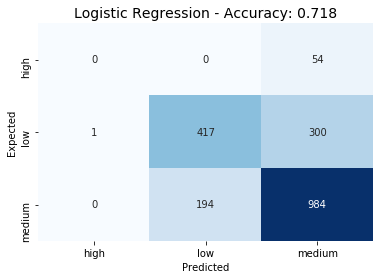

In [19]:
#fit_predict_score("Logistic Regression", wqp_lr, wqp_train_SX, wqp_train_y, wqp_test_SX, wqp_test_y)

In [20]:
#the intercept term from the logistic regression is the log odds of our base reference term
print("Intercept:\n", wqp_lr.intercept_)
print("Coefficient:\n", wqp_lr.coef_)

Intercept:
 [-2.23876911  0.76544336  1.47332574]
Coefficient:
 [[ 0.33344207 -0.28445686  0.02134858  0.79805168 -0.08496491  0.3295359
  -0.274384   -0.7275118   0.27761447  0.1528201   0.62861911]
 [-0.20504896  0.52251909  0.05106597 -0.56540798  0.05320671 -0.31453841
   0.34685416  0.38548903 -0.16710914 -0.21646803 -0.85558205]
 [-0.12839312 -0.23806223 -0.07241455 -0.2326437   0.03175821 -0.01499749
  -0.07247016  0.34202277 -0.11050533  0.06364793  0.22696294]]


### Decision Tree Classifier

In [21]:
#wqp_dt = DecisionTreeClassifier()

Accuracy Score: 0.722
Classification Report: 
              precision    recall  f1-score   support

        high       0.25      0.30      0.27        54
         low       0.67      0.69      0.68       718
      medium       0.78      0.76      0.77      1178

    accuracy                           0.72      1950
   macro avg       0.57      0.58      0.57      1950
weighted avg       0.72      0.72      0.72      1950



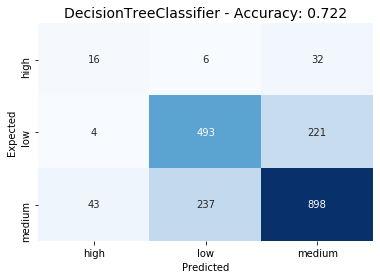

In [22]:
#fit_predict_score("DecisionTreeClassifier", wqp_dt, wqp_train_SX, wqp_train_y, wqp_test_SX, wqp_test_y)